In [1]:
import pandas as pd
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', None)
import os
import re

In [2]:
all_cd = '/Users/colinwan/Desktop/DS-GA_1003_Spring_2022_grades.csv'
all_df = pd.read_csv(all_cd)

In [3]:
cd = '/Users/colinwan/Desktop/1003 hw grades/'

In [4]:
all_df = all_df.loc[:, ~all_df.columns.str.contains('Submission Time')]
all_df['acc_late_days'] = 0
all_df['net_id'] = all_df['Email'].str.strip('@nyu.edu')
all_df.head()

,Name,SID,Email,hw1,hw1 - Max Points,hw1 - Lateness (H:M:S),hw2,hw2 - Max Points,hw2 - Lateness (H:M:S),hw3,...,hw6 - Lateness (H:M:S),hw7,hw7 - Max Points,hw7 - Lateness (H:M:S),Final Exam,Final Exam - Max Points,Final Exam - Lateness (H:M:S),Total Lateness (H:M:S),acc_late_days,net_id
0,Aashiq Mohamed Baig,NaN,amb1558@nyu.edu,32.0,37.0,00:00:00,40.5,41.0,00:00:00,69.0,...,00:00:00,15.5,31.0,00:00:00,65.5,100.0,00:00:00,25:17:59,0,amb1558
1,Adeet Patel,NaN,ajp756@nyu.edu,30.0,37.0,46:39:28,34.0,41.0,00:00:00,43.0,...,17:46:08,8.0,31.0,00:00:00,49.5,100.0,01:14:36,65:40:12,0,ajp756
2,Aditya Srikanth,NaN,aks9136@nyu.edu,29.0,37.0,00:00:00,34.0,41.0,00:00:00,39.5,...,00:00:00,8.0,31.0,00:00:00,41.0,100.0,00:00:00,19:45:13,0,aks9136
3,Ailene Zhang,NaN,az1509@nyu.edu,27.0,37.0,00:00:00,36.0,41.0,00:00:00,58.5,...,40:43:38,12.0,31.0,38:58:56,34.0,100.0,00:00:00,100:23:12,0,az1509
4,Aiqing Li,N17327836,al5452@nyu.edu,33.0,37.0,22:40:41,39.0,41.0,22:52:58,55.5,...,20:16:46,12.0,31.0,00:00:00,56.0,100.0,00:00:00,135:23:53,0,al5452


In [5]:
info_col = ['Name', 'SID', 'Email', 'net_id','acc_late_days']
info_df = all_df.loc[:,info_col]


In [6]:
opt_q = {'hw1': [15],
         'hw2': [21,22,23,24,25],
         'hw3': [14, 32,33,34,35],
         'hw4': [8],
         'hw5': [11,12,13,14,15,16],
         'hw6': [10,11,12],
         'hw7': [12,13,14],
        }
bonous = {'hw3':[1,2,3,13,29,30,31]}
bonus_points = {'hw3':[3,1,4,1,3,3,2]}

In [7]:
def add_late(x):
    sub_late = x['hw'+str(i)+' - Lateness (H:M:S)']
    late_days = 0
    
    if sub_late<'24:00:00' and sub_late>'00:00:00':
        late_days = 1
    elif sub_late>'24:00:00' and sub_late<'48:00:00':
        late_days = 2
    elif sub_late>'48:00:00':
        late_days = int(sub_late[:2])//24+1
        p = late_days - min(2, 7-late_days)
        x['final_score'] = x['score'] * 0.8**p
        x['acc_late_days'] += min(2, 7-late_days)
        x['penalty'] = 0.8**p
    
    if late_days <=2:
        if x['acc_late_days'] + late_days<=7:
            x['acc_late_days']+= late_days
            x['final_score'] = x['score']
        else:
            x['final_score'] = x['score']*0.8**(late_days+x['acc_late_days']-7)
            x['penalty'] = 0.8**(late_days+x['acc_late_days']-7)
            x['acc_late_days'] = 7
    x['late']=late_days
    
    return x

        
def split_score(df, optional_questions):
    mandatory_total = 0
    optional_total = 0
    optional_keys = []
    mandatory_keys = []
    for key in df.keys():
        if "q" not in key.lower():
            continue
        tot_question_points = re.findall('\(.*?\)', key)
        tot_question_points = float(tot_question_points[0].split(" ")[0][1:])
        optional = False
        for item in optional_questions:
            if "q"+str(item) in key.lower():
                # print(item, ", Full Key: ", key, ", Total Question Points: ", tot_question_points)
                optional = True
                break
        if not optional:
            mandatory_total+=tot_question_points
            mandatory_keys.append(key)
        else:
            optional_keys.append(key)
            optional_total+=tot_question_points
        

    df['Mandatory Sum'] = df[mandatory_keys].sum(axis=1)
    df['Mandatory Total'] = mandatory_total
    df['Optional Sum'] = df[optional_keys].sum(axis=1)
    df['Optional Total'] = optional_total
    return df



In [8]:
agg_df = info_df
for hw in os.listdir(cd):
    print(hw)
    hw_df = pd.read_csv(cd+hw)
    hw_name = hw.split('_')[0]
    split_hw = split_score(hw_df, opt_q[hw_name])
    split_hw = split_hw[['Name', 'SID', 'Email','Mandatory Sum', 'Mandatory Total', 'Optional Sum', 'Optional Total','Lateness (H:M:S)']]
    split_hw.columns = ['Name', 'SID', 'Email',hw_name, hw_name+' - Max Points', hw_name +' - Optional Sum',hw_name +' - Optional Max Points',hw_name+ ' - Lateness (H:M:S)']
    
    agg_df = pd.merge(agg_df,split_hw,how='outer',left_on=['Name', 'SID', 'Email'],right_on=['Name', 'SID', 'Email'])
agg_df['acc_late_days'] = 0
agg_df['net_id'] = agg_df['Email'].str.strip('@nyu.edu')    


hw1_scores.csv
hw4_scores.csv
hw3_scores.csv
hw6_scores.csv
hw5_scores.csv
hw7_scores.csv
hw2_scores.csv


In [9]:
agg_df['hw3 - Max Points'] = agg_df['hw3 - Max Points'] - sum(bonus_points['hw3'])

In [15]:
# Check Late Days & Adjust HW Grades
for i in range(1,8):
    print(i)
    cur_df = agg_df.loc[:, agg_df.columns.str.contains('hw'+str(i))]
    cur_df['acc_late_days'] = info_df.loc[:,'acc_late_days']
    cur_df['score'] = (cur_df.iloc[:,0]/cur_df.iloc[:,1]).clip(upper=1)
    cur_df['optional_score'] = (cur_df.iloc[:,2]/cur_df.iloc[:,3]).clip(upper=1)
    cur_df['penalty'] = 0
    cur_df['late'] = 0
    cur_df['final_score'] = 0
    cur_df.fillna("00:00:00", inplace=True)

    new_df = cur_df.apply(add_late,axis=1)


    info_df['acc_late_days'] = new_df['acc_late_days']
    info_df['hw'+str(i)+'_late_time'] = new_df['hw'+str(i)+' - Lateness (H:M:S)']
    info_df['hw'+str(i)+'_score'] = new_df['score']
    info_df['hw'+str(i)+'_penalty'] = new_df['penalty']
    info_df['hw'+str(i)+'_late'] = new_df['late']
    info_df['hw'+str(i)+'_final_score'] = new_df['final_score']
    info_df['hw'+str(i)+'_optional_score'] = new_df['optional_score']
#     info_df['hw'+str(i)+'_optional_max'] = new_df['optional_']



1
2
3
4
5
6
7


In [16]:
# Midterm
midterm = all_df.loc[:, all_df.columns.str.contains('Midterm')]

info_df['midterm_grade'] = midterm.iloc[:,0]/midterm.iloc[:,1]
info_df['midterm_late'] = midterm.iloc[:,-1]>"00:00:00"
info_df['midterm_final_score'] = info_df['midterm_grade'] - info_df['midterm_late']*0.02


In [17]:
# Final
final = all_df.loc[:, all_df.columns.str.contains('Final')]

info_df['final_grade'] = final.iloc[:,0]/final.iloc[:,1]
info_df['final_late'] = final.iloc[:,-1]>"00:00:00"
info_df['final_final_score'] = info_df['final_grade'] - info_df['final_late']*0.02


In [39]:
hist_data = info_df.loc[:,info_df.columns.str.contains('optional')].mean(1)
cut_off1, cut_off2 = hist_data.quantile(0.75), hist_data.quantile(0.5)
info_df['optional_final_score'] = (hist_data>cut_off2)*0.01 + (hist_data>cut_off1)*0.01

In [40]:
ind = info_df.columns.str.contains('final_score')
ind[:4] = True
final_grades = info_df.loc[:,ind]
final_grades

,Name,SID,Email,net_id,hw1_final_score,hw2_final_score,hw3_final_score,hw4_final_score,hw5_final_score,hw6_final_score,midterm_final_score,final_final_score,hw7_final_score,optional_final_score
0,Aashiq Mohamed Baig,NaN,amb1558@nyu.edu,amb1558,0.914286,1.000000,1.000000,1.000000,0.979167,1.000000,0.833333,0.6550,0.958333,0.02
1,Adeet Patel,NaN,ajp756@nyu.edu,ajp756,0.857143,0.944444,1.000000,0.942308,0.916667,0.923077,0.746667,0.4750,0.812500,0.00
2,Aditya Srikanth,NaN,aks9136@nyu.edu,aks9136,0.828571,0.944444,0.918605,1.000000,0.979167,0.951923,0.700000,0.4100,0.750000,0.00
3,Ailene Zhang,NaN,az1509@nyu.edu,az1509,0.757143,0.888889,1.000000,0.961538,0.937500,0.971154,0.706667,0.3400,0.800000,0.00
4,Aiqing Li,N17327836,al5452@nyu.edu,al5452,0.942857,0.766667,0.800000,0.800000,0.716667,0.784615,0.760000,0.5600,1.000000,0.01
5,Alejandro Saez,NaN,as15796@nyu.edu,as15796,0.814286,0.944444,1.000000,0.884615,0.437500,0.961538,0.800000,0.6950,0.958333,0.02
6,Alexander Herron,NaN,ah5865@nyu.edu,ah5865,0.771429,0.958333,1.000000,1.000000,0.875000,1.000000,0.786667,0.3700,1.000000,0.00
7,Alexandre Vives,NaN,av2926@nyu.edu,av2926,0.985714,0.958333,1.000000,0.961538,0.760417,0.884615,0.933333,0.6125,0.812500,0.02
8,Anant Rai,NaN,ar7420@nyu.edu,ar7420,0.900000,0.958333,0.800000,0.961538,0.586667,0.603077,0.853333,0.6850,0.666667,0.02
9,Andre Chen,NaN,alc9635@nyu.edu,alc9635,0.985714,0.972222,1.000000,0.942308,0.979167,1.000000,0.846667,0.6700,1.000000,0.00


In [53]:
raw_final = final_grades.loc[:, final_grades.columns.str.contains('hw')].mean(1)*0.4 \
                    + (final_grades['midterm_final_score']+final_grades['final_final_score'])*0.3 + final_grades['optional_final_score']
final_grades['raw_final'] = raw_final

In [57]:
final_ind = [0,1,2,3,14]
final_grades.iloc[:, final_ind].to_csv('Just_final_grades.csv')

<AxesSubplot:>

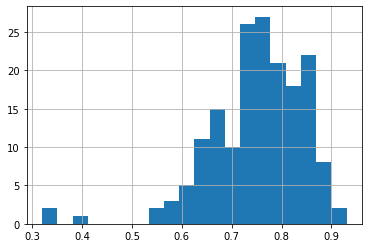

In [51]:
final_grades['raw_final'].hist(bins=20)

In [56]:
final_grades.to_csv('DSGA1003_SP22_Final_Raw.csv')